In [ ]:
# https://docs.ray.io/en/latest/serve/develop-and-deploy.html

# Deploy a pre-trained FLAN-T5 text gen model on Ray Serve

## What is Ray Serve?

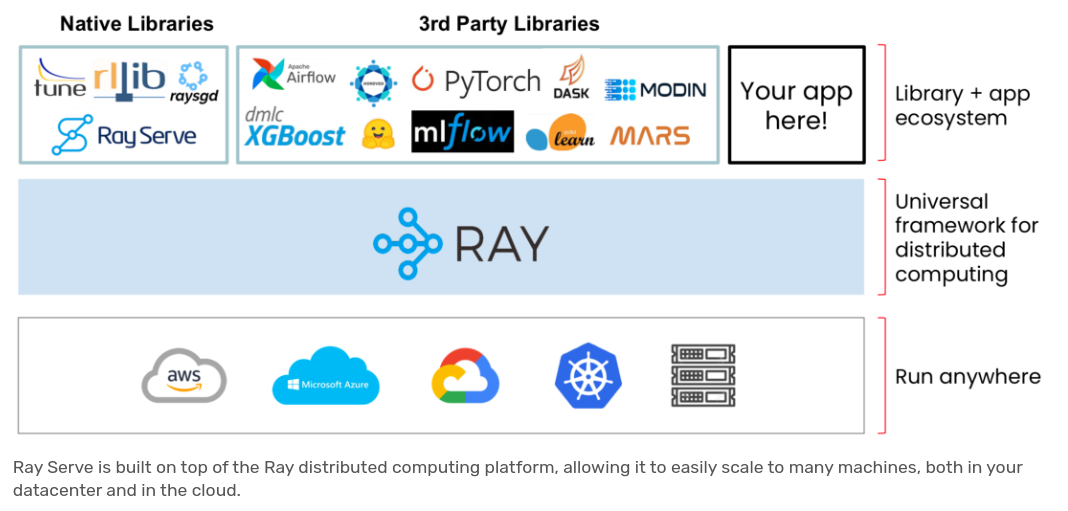

In [2]:
Image("../../reports/figures/ray-serve-intro.png")

Ray Serve is an easy-to-use scalable model serving library built on Ray. Some advantages of the library include:

- Scalability: Horizontally scale across hundreds of processes or machines, while keeping the overhead in single-digit milliseconds

- Multi-model composition: Easily compose multiple models, mix model serving with business logic, and independently scale components, without complex microservices.

- Batching: Native support for batching requests to better utilize hardware and improve throughput.

- FastAPI Integration: Scale an existing FastAPI server easily or define an HTTP interface for your model using its simple, elegant API.

- Framework-agnostic: Use a single toolkit to serve everything from deep learning models built with frameworks like PyTorch, Tensorflow and Keras, to Scikit-Learn models, to arbitrary Python business logic.

## Where Ray Serve fits in the ML serving Space

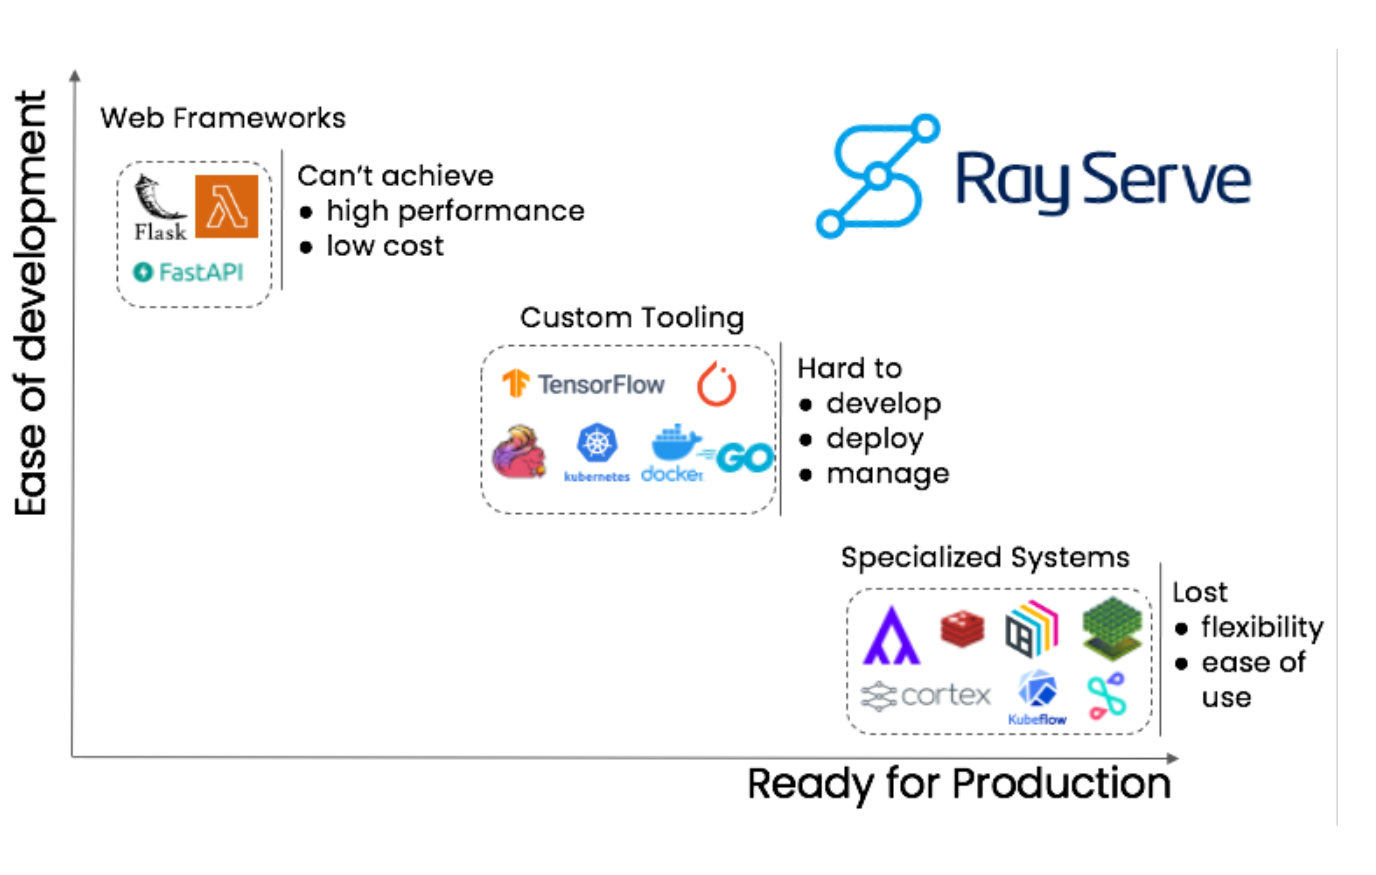

In [4]:
Image(filename='../../reports/figures/ray-serve-comparison.png')

[Reference](https://www.anyscale.com/blog/serving-ml-models-in-production-common-patterns)

In the world of using machine learning for different tasks, there's a common challenge. It's about finding the right balance between making things easy at the start and making them work really well when used in important situations.

- Simple Start :
Many people begin by using simple tools like Flask or FastAPI to make their machine learning models work. These tools are like easy-to-use templates and are great for small tests. However, when they need to handle a lot of work or do things quickly, they often struggle and become expensive to use.

- Custom Solutions :
When simple tools can't handle the job, some people create their own solutions by combining different tools. This is like building a custom machine, but it can be tough to create, set up, and manage.

- Specialized Systems : 
There are also systems made just for using machine learning in serious situations. These systems are really good at doing their job, but they might not be very flexible, and they can be hard to learn how to use.

- Ray Serve :
Ray Serve is like a tool that tries to be both easy to use and ready for important work. It's made especially for using machine learning models, and it's meant to be simple to use, easy to set up, and good for important tasks.

## Ray Serve and Codeflare

CodeFlare is a managed Kubernetes platform that provides a user-friendly interface for deploying and managing Ray applications. Ray Serve can be deployed on CodeFlare clusters using the CodeFlare SDK. CodeFlare also provides a number of features that make it well-suited for deploying Ray Serve applications

In [1]:
import requests
from starlette.requests import Request
from typing import Dict

from transformers import pipeline

import ray
from ray import serve
from IPython.display import Image

from fastapi import FastAPI

from codeflare_sdk.cluster.cluster import Cluster, ClusterConfiguration
from codeflare_sdk.cluster.auth import TokenAuthentication
from codeflare_sdk.utils import generate_cert

**Create and configure a Ray cluster using the CodeFlare SDK.**

In [18]:
# Create and configure our cluster object (and appwrapper)
cluster = Cluster(ClusterConfiguration(
    name='rayservice-surya',
    namespace='default',
    num_workers=2,
    min_cpus=2,
    max_cpus=2,
    min_memory=8,
    max_memory=8,
    image="quay.io/project-codeflare/ray:2.5.0-py38-cu116",
    num_gpus=1,
    instascale=True,
    machine_types=["m5.xlarge", "g4dn.xlarge"] 
))

Written to: rayservice-surya.yaml


In [20]:
# NOTE: before running cluster.up() you need to manually add the container port 8000 field to the raytest.yaml
#    ports:
#    - containerPort: 8000
#    name: serve

cluster.up()

In [21]:
# WARNING: using instascale=True in your ClusterConfiguration above assumes
# that you have instascale properly installed and enabled on your cluster.
# It can take around 15 minutes for your pods to scale up. 
# if this hangs for too long, please stop it with `cluster.down()`
#cluster.wait_ready()

In [26]:
ray_cluster_uri = cluster.cluster_uri()

In [27]:
ray_cluster_uri

'ray://rayservice-surya-head-svc.default.svc:10001'

**Install the necessary Python libraries on the Ray cluster.**

In [34]:
#install additionall libraries that will be required for model serving
runtime_env = {"pip": ["transformers", "datasets", "evaluate", "pyarrow<7.0.0", "accelerate"]}

ray.shutdown()

ray.init(address=ray_cluster_uri, runtime_env=runtime_env)

print("Ray cluster is up and running: ", ray.is_initialized())

Ray cluster is up and running:  True


In [35]:
ray_dashboard_uri = cluster.cluster_dashboard_uri()
ray_cluster_uri = cluster.cluster_uri()
print(ray_dashboard_uri)
print(ray_cluster_uri)

http://ray-dashboard-rayservice-surya-default.apps.et-cluster.6mwp.p1.openshiftapps.com
ray://rayservice-surya-head-svc.default.svc:10001


**Define a Ray Serve deployment for the text generation model.**

In [36]:
# 1: Wrap the pretrained  flan-t5 instruction model in a Serve deployment. #change name to text gen
@serve.deployment(num_replicas=2, ray_actor_options={"num_gpus":1})
#@serve.ingress(app)
class textgenerationdeployment:
    def __init__(self):
        self._model = pipeline("text2text-generation", model="google/flan-t5-large", device_map="auto")

    def __call__(self, request: Request) -> Dict:
        return self._model(request.query_params["text"])[0]
    
    

Now, in order to start the ray serve application and making it available to clients. It is done by serve.run() function. 

It takes two argument, 

- The deployment to start. In this case, the deployment is textgenerationdeployment.
- The host on which to expose the Ray Serve application. In this case, the host is 0.0.0.0, which means that the Ray Serve application will be available to clients on all IP addresses.
Once the serve.run() function is called, the Ray Serve application will be started and the model will be exposed as an endpoint. This means that clients will be able to send requests to the Ray Serve application to generate text

In [37]:
# 2: Starts the server and exposes the model as an endpoint
serve.run(textgenerationdeployment.bind(), host="0.0.0.0")

(ServeController pid=505) INFO 2023-09-15 13:22:45,358 controller 505 deployment_state.py:1298 - Deploying new version of deployment default_textgenerationdeployment.
(ServeController pid=505) INFO 2023-09-15 13:22:45,385 controller 505 deployment_state.py:1537 - Adding 2 replicas to deployment default_textgenerationdeployment.
(HTTPProxyActor pid=543) INFO:     Started server process [543]


(autoscaler +52s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +52s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


(ServeController pid=505) WARNING 2023-09-15 13:23:15,440 controller 505 deployment_state.py:1849 - Deployment "default_textgenerationdeployment" has 2 replicas that have taken more than 30s to be scheduled. This may be caused by waiting for the cluster to auto-scale, or waiting for a runtime environment to install. Resources required for each replica: {"CPU": 1, "GPU": 1.0}, resources available: {"CPU": 2.0}.


(autoscaler +1m27s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


(ServeController pid=505) WARNING 2023-09-15 13:23:45,473 controller 505 deployment_state.py:1849 - Deployment "default_textgenerationdeployment" has 2 replicas that have taken more than 30s to be scheduled. This may be caused by waiting for the cluster to auto-scale, or waiting for a runtime environment to install. Resources required for each replica: {"CPU": 1, "GPU": 1.0}, resources available: {"CPU": 2.0}.


(autoscaler +2m2s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


(ServeController pid=505) WARNING 2023-09-15 13:24:15,563 controller 505 deployment_state.py:1849 - Deployment "default_textgenerationdeployment" has 2 replicas that have taken more than 30s to be scheduled. This may be caused by waiting for the cluster to auto-scale, or waiting for a runtime environment to install. Resources required for each replica: {"CPU": 1, "GPU": 1.0}, resources available: {"CPU": 2.0}.


(autoscaler +2m37s) Error: No available node types can fulfill resource request {'GPU': 1.0, 'CPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


(ServeController pid=505) WARNING 2023-09-15 13:24:45,651 controller 505 deployment_state.py:1849 - Deployment "default_textgenerationdeployment" has 2 replicas that have taken more than 30s to be scheduled. This may be caused by waiting for the cluster to auto-scale, or waiting for a runtime environment to install. Resources required for each replica: {"CPU": 1, "GPU": 1.0}, resources available: {"CPU": 2.0}.


(autoscaler +3m12s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


(ServeController pid=505) WARNING 2023-09-15 13:25:15,740 controller 505 deployment_state.py:1849 - Deployment "default_textgenerationdeployment" has 2 replicas that have taken more than 30s to be scheduled. This may be caused by waiting for the cluster to auto-scale, or waiting for a runtime environment to install. Resources required for each replica: {"CPU": 1, "GPU": 1.0}, resources available: {"CPU": 2.0}.


(autoscaler +3m47s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


(ServeController pid=505) WARNING 2023-09-15 13:25:45,813 controller 505 deployment_state.py:1849 - Deployment "default_textgenerationdeployment" has 2 replicas that have taken more than 30s to be scheduled. This may be caused by waiting for the cluster to auto-scale, or waiting for a runtime environment to install. Resources required for each replica: {"CPU": 1, "GPU": 1.0}, resources available: {"CPU": 2.0}.
(ServeController pid=505) WARNING 2023-09-15 13:26:15,906 controller 505 deployment_state.py:1849 - Deployment "default_textgenerationdeployment" has 2 replicas that have taken more than 30s to be scheduled. This may be caused by waiting for the cluster to auto-scale, or waiting for a runtime environment to install. Resources required for each replica: {"CPU": 1, "GPU": 1.0}, resources available: {"CPU": 2.0}.


(autoscaler +4m22s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


(ServeController pid=505) WARNING 2023-09-15 13:26:45,987 controller 505 deployment_state.py:1849 - Deployment "default_textgenerationdeployment" has 2 replicas that have taken more than 30s to be scheduled. This may be caused by waiting for the cluster to auto-scale, or waiting for a runtime environment to install. Resources required for each replica: {"CPU": 1, "GPU": 1.0}, resources available: {"CPU": 2.0}.


(autoscaler +4m57s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


(ServeController pid=505) WARNING 2023-09-15 13:27:16,050 controller 505 deployment_state.py:1849 - Deployment "default_textgenerationdeployment" has 2 replicas that have taken more than 30s to be scheduled. This may be caused by waiting for the cluster to auto-scale, or waiting for a runtime environment to install. Resources required for each replica: {"CPU": 1, "GPU": 1.0}, resources available: {"CPU": 2.0}.
(ServeController pid=505) WARNING 2023-09-15 13:27:46,119 controller 505 deployment_state.py:1849 - Deployment "default_textgenerationdeployment" has 2 replicas that have taken more than 30s to be scheduled. This may be caused by waiting for the cluster to auto-scale, or waiting for a runtime environment to install. Resources required for each replica: {"CPU": 1, "GPU": 1.0}, resources available: {"CPU": 4.0}.
(ServeController pid=505) WARNING 2023-09-15 13:28:16,215 controller 505 deployment_state.py:1849 - Deployment "default_textgenerationdeployment" has 2 replicas that have t

RayServeSyncHandle(deployment='default_textgenerationdeployment')

The output RayServeSyncHandle(deployment='default_textgenerationdeployment') indicates that the Ray Serve application has been started successfully and the model is now exposed as an endpoint.

In [38]:
serve.get_deployment("default_textgenerationdeployment")

Deployment(name=default_textgenerationdeployment,version=None,route_prefix=/)


The output Deployment(name=default_textgenerationdeployment,version=None,route_prefix=/) indicates that the deployment named default_textgenerationdeployment is running and the model is exposed as an endpoint at the root path /.

In [39]:
cluster.cluster_dashboard_uri()

'http://ray-dashboard-rayservice-surya-default.apps.et-cluster.6mwp.p1.openshiftapps.com'

In [42]:
# 3: Query the deployment and print the result from inside the cluster.
requests.get("http://rayservice-surya-head-svc.default.svc.cluster.local:8000/", 
              params={"text": "Open Source Summit is the "}).content

b'{"generated_text": "Open Source Summit, the annual conference for the Open Source community. It is the largest gathering of"}'

(ServeReplica:default_textgenerationdeployment pid=209, ip=10.128.160.21) INFO 2023-09-15 13:34:23,464 default_textgenerationdeployment default_textgenerationdeployment#JleOdo SWifDvdyZA / default replica.py:654 - __CALL__ OK 575.9ms


By querying the text generation deployment through the endpoint, we can generate text.

In [ ]:
# 3: Query the deployment and print the result from an exposed route.
# an Openshift Route called ray-service must be created for this to work
requests.post("http://ray-service-default.<CLUSTER_ADDRESS>", 
              params={"text": "What is the purpose of AI?"}).content

In [ ]:
serve.shutdown()

In [43]:
cluster.down()

Log channel is reconnecting. Logs produced while the connection was down can be found on the head node of the cluster in `ray_client_server_[port].out`
2023-09-15 21:04:17,717	WARNING dataclient.py:403 -- Encountered connection issues in the data channel. Attempting to reconnect.
2023-09-15 21:04:47,748	WARNING dataclient.py:410 -- Failed to reconnect the data channel
2023-09-15 21:04:47,749	WARNING long_poll.py:149 -- LongPollClient connection failed, shutting down.


Ray Serve is a powerful and flexible model serving library that can be used to deploy machine learning models of all types, including text generation models. CodeFlare is a managed Kubernetes platform that makes it easy to deploy and manage Ray Serve applications. By using Ray Serve and CodeFlare together, you can deploy your machine learning models to production quickly and easily.